<a href="https://colab.research.google.com/github/Subhoshri/Alphabet-Sign-Language-Detection/blob/main/Sign_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
import sklearn
!pip install visualkeras
import visualkeras
!pip install ann-visualizer
import ann_visualizer
from ann_visualizer.visualize import ann_viz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=a6b9f2594ff0822625caf5991c9f72fb483379edf2527bb94f14895e1f50e679
  Stored in directory: /root/.cache/pip/wheels/28/4a/ad/e82da1aad2994e42bf0f4b1d403fdd8a64dfc38ae2c8a5daa4
Successfully built ann-visualizer


In [2]:
 !pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"up14cp9225","key":"fb2dc9c6bc4010df97628a90a762f1f3"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl

Dataset URL: https://www.kaggle.com/datasets/prathumarikeri/indian-sign-language-isl
License(s): CC-BY-SA-4.0


In [8]:
!mkdir dataset

In [9]:
!unzip indian-sign-language-isl.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Indian/V/819.jpg  
  inflating: dataset/Indian/V/82.jpg  
  inflating: dataset/Indian/V/820.jpg  
  inflating: dataset/Indian/V/821.jpg  
  inflating: dataset/Indian/V/822.jpg  
  inflating: dataset/Indian/V/823.jpg  
  inflating: dataset/Indian/V/824.jpg  
  inflating: dataset/Indian/V/825.jpg  
  inflating: dataset/Indian/V/826.jpg  
  inflating: dataset/Indian/V/827.jpg  
  inflating: dataset/Indian/V/828.jpg  
  inflating: dataset/Indian/V/829.jpg  
  inflating: dataset/Indian/V/83.jpg  
  inflating: dataset/Indian/V/830.jpg  
  inflating: dataset/Indian/V/831.jpg  
  inflating: dataset/Indian/V/832.jpg  
  inflating: dataset/Indian/V/833.jpg  
  inflating: dataset/Indian/V/834.jpg  
  inflating: dataset/Indian/V/835.jpg  
  inflating: dataset/Indian/V/836.jpg  
  inflating: dataset/Indian/V/837.jpg  
  inflating: dataset/Indian/V/838.jpg  
  inflating: dataset/Indian/V/839.jpg  
  inflating: dataset/Indian/V/8

Loading the dataset path onto data.

In [58]:
data='/content/dataset/Indian'

We will now apply *Gaussian Blur* to smooth the edges and reduce noise in the images. Also we'll find the appropriate threshold to distinguish the hand gesture from the background using *Adaptive Thresholding* and *Otsu Thresholding*. These features are applied to all the images in the dataset.

Furthermore, we split the dataset into 80% training and 20% test data. Every image is scaled to 64 x 64 pixels and normalised.

In [59]:
def load_images():
    images, labels = [], []
    idx = -1
    folders = sorted(os.listdir(data))

    for folder in folders:
        idx += 1
        print("Loading images from folder:", folder)

        for image in os.listdir(os.path.join(data, folder)):
            img = cv2.imread(os.path.join(data, folder, image), 0)
            img = edge_detection(img)
            img = cv2.resize(img, (64, 64))
            img = img_to_array(img)
            images.append(img)
            labels.append(idx)

    images = np.array(images).astype('float32') / 255.0
    labels = to_categorical(labels, num_classes=35)

    return images, labels

def edge_detection(image):
    minValue = 70
    blur = cv2.GaussianBlur(image, (5,5), 2)
    th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return res

Now we load the images from folders while applying *edge_detection* function.

In [60]:
images, labels = load_images()

Loading images from folder: 1
Loading images from folder: 2
Loading images from folder: 3
Loading images from folder: 4
Loading images from folder: 5
Loading images from folder: 6
Loading images from folder: 7
Loading images from folder: 8
Loading images from folder: 9
Loading images from folder: A
Loading images from folder: B
Loading images from folder: C
Loading images from folder: D
Loading images from folder: E
Loading images from folder: F
Loading images from folder: G
Loading images from folder: H
Loading images from folder: I
Loading images from folder: J
Loading images from folder: K
Loading images from folder: L
Loading images from folder: M
Loading images from folder: N
Loading images from folder: O
Loading images from folder: P
Loading images from folder: Q
Loading images from folder: R
Loading images from folder: S
Loading images from folder: T
Loading images from folder: U
Loading images from folder: V
Loading images from folder: W
Loading images from folder: X
Loading im

We will shuffle the data to prevent any bias from coming into the model due to the sorted dataset.

In [61]:
from sklearn.utils import shuffle
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
x_train, y_train = shuffle(x_train, y_train, random_state=17)

Augmenting data to remove any bias.

In [63]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

Plotting an example from the dataset after it has been cleaned.

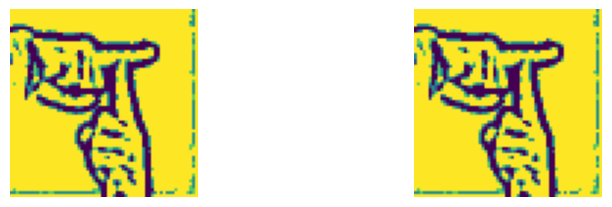

In [64]:
alpha=[chr(c) for c in range(65,91)]
uniq,count=np.unique(y_train,return_counts=True)

j=1
plt.figure(figsize=(20,20))
for i in uniq:
    plt.subplot(7,4,j)
    plt.imshow(x_train[np.where(y_train==np.array(i))[0][0]])
    plt.axis('off')
    j=j+1

Mapping each character to an index starting from 0.

In [65]:
map_characters = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: 'A', 10: 'B', 11: 'C', 12: 'D',
                  13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P',
                  25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z'}

Now we train the CNN Model to predict sign language successfully.

In [73]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Multiply, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

inputs = Input(shape=(64, 64, 1))

# Conv Block 1
x = Conv2D(32, (3,3), activation='relu', padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)

# Conv Block 2
x = Conv2D(64, (3,3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)

# Conv Block 3
x = Conv2D(128, (3,3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)

attention = Conv2D(128, (1,1), activation='sigmoid', padding="same")(x)
x = Multiply()([x, attention])

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = Dense(35, activation='softmax')(x)

model = Model(inputs, outputs)

In [74]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=5000, alpha=0.0001
)
adam = Adam(learning_rate=lr_schedule)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(x_train):
    x_tr, x_val = x_train[train_index], x_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    history = model.fit(datagen.flow(x_tr, y_tr, batch_size=32), validation_data=(x_val, y_val), epochs=20, verbose=2)

Epoch 1/20
855/855 - 31s - 36ms/step - accuracy: 0.9925 - loss: 0.1577 - val_accuracy: 0.3974 - val_loss: 2.7909
Epoch 2/20
855/855 - 29s - 33ms/step - accuracy: 0.9967 - loss: 0.0930 - val_accuracy: 0.3747 - val_loss: 3.8704
Epoch 3/20
855/855 - 19s - 22ms/step - accuracy: 0.9981 - loss: 0.0603 - val_accuracy: 0.6423 - val_loss: 1.1854
Epoch 4/20
855/855 - 17s - 20ms/step - accuracy: 0.9994 - loss: 0.0456 - val_accuracy: 0.7918 - val_loss: 0.7855
Epoch 5/20
855/855 - 21s - 24ms/step - accuracy: 0.9996 - loss: 0.0398 - val_accuracy: 0.7604 - val_loss: 0.8348
Epoch 6/20
855/855 - 17s - 19ms/step - accuracy: 0.9997 - loss: 0.0388 - val_accuracy: 0.7621 - val_loss: 0.8373
Epoch 7/20
855/855 - 18s - 22ms/step - accuracy: 0.9997 - loss: 0.0388 - val_accuracy: 0.7532 - val_loss: 0.8624
Epoch 8/20
855/855 - 19s - 22ms/step - accuracy: 0.9998 - loss: 0.0389 - val_accuracy: 0.7525 - val_loss: 0.8712
Epoch 9/20
855/855 - 18s - 21ms/step - accuracy: 0.9996 - loss: 0.0390 - val_accuracy: 0.7542 - 

In [78]:
model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 32)     │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64, 64, 32)     │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 32, 32, 64)     │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 16, 16, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 8, 8, 128)      │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 8, 8, 128)      │         16,512 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 8, 8, 128)      │              0 │ max_pooling2d_23[0][0… │
│                           │                        │                │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ multiply_4[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 35)             │          4,515 │ dense_10[0][0]         │
└──────────────────────

 Total params: 392,426 (1.50 MB)

 Trainable params: 130,659 (510.39 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 261,319 (1020.78 KB)

We can visualize the CNN model.

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


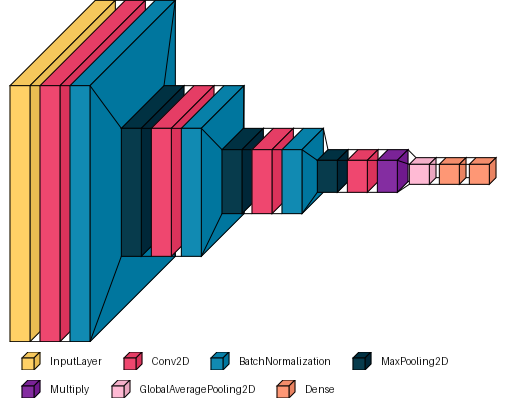

In [79]:
visualkeras.layered_view(model,legend=True)

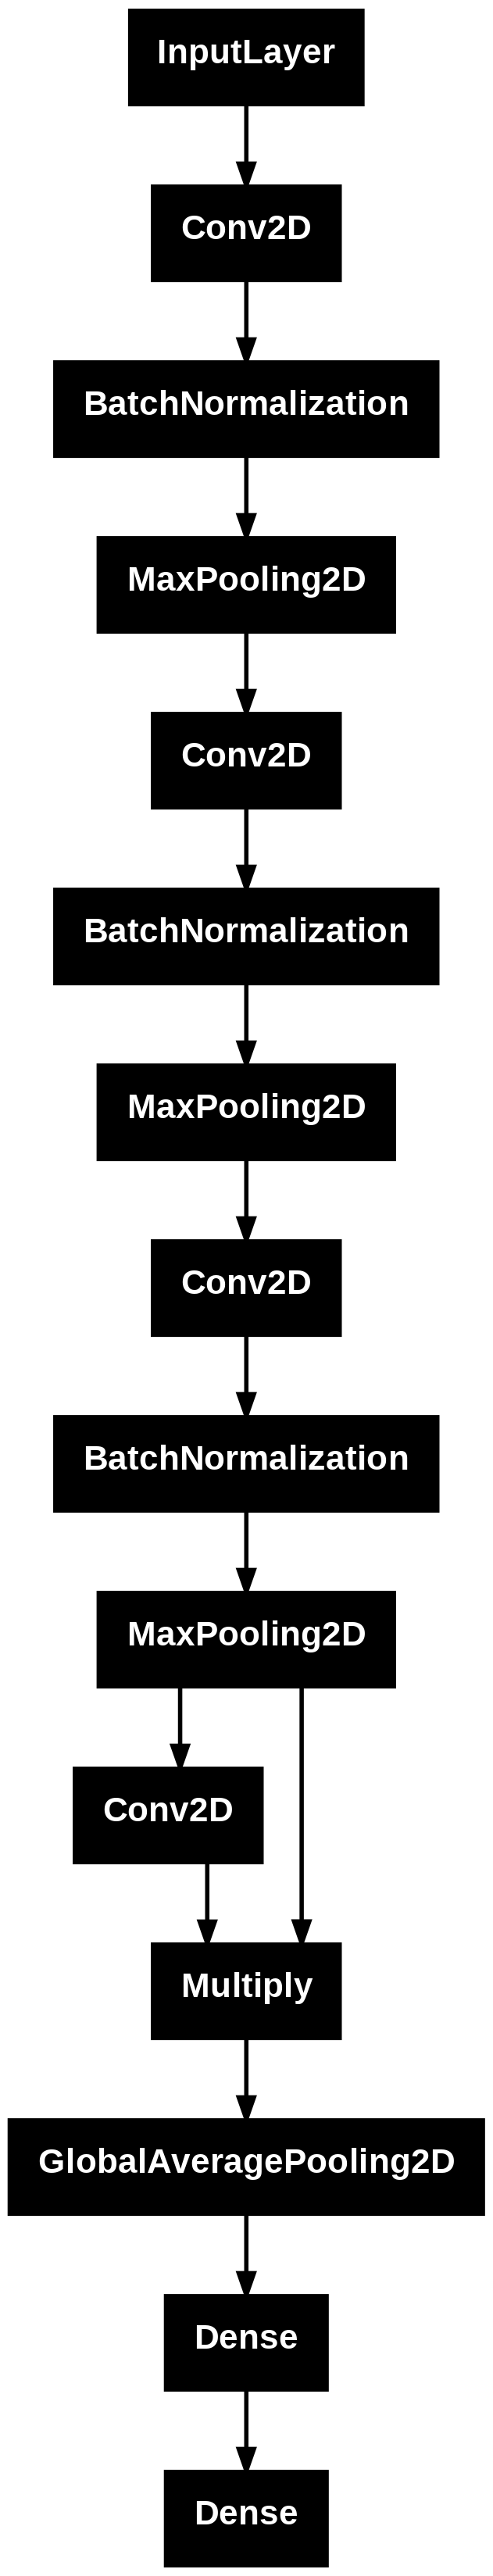

In [80]:
keras.utils.plot_model(model)

In [81]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {score[1]*100:.2f}%\n")


Final Test Accuracy: 75.23%



In [82]:
y_pred = model.predict(x_test, verbose=1)
Y_pred_classes = np.argmax(y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [83]:
print(metrics.classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.13      0.23       240
           1       1.00      0.00      0.01       240
           2       1.00      0.80      0.89       240
           3       0.82      1.00      0.90       240
           4       0.70      1.00      0.82       240
           5       0.00      0.00      0.00       240
           6       1.00      1.00      1.00       240
           7       1.00      1.00      1.00       240
           8       1.00      0.90      0.95       240
           9       1.00      0.20      0.33       240
          10       0.97      1.00      0.99       240
          11       0.96      1.00      0.98       289
          12       1.00      0.99      0.99       240
          13       0.28      1.00      0.43       240
          14       1.00      0.35      0.51       240
          15       0.00      0.00      0.00       240
          16       0.67      0.99      0.80       240
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [84]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [85]:
class_labels = list(map_characters.values())

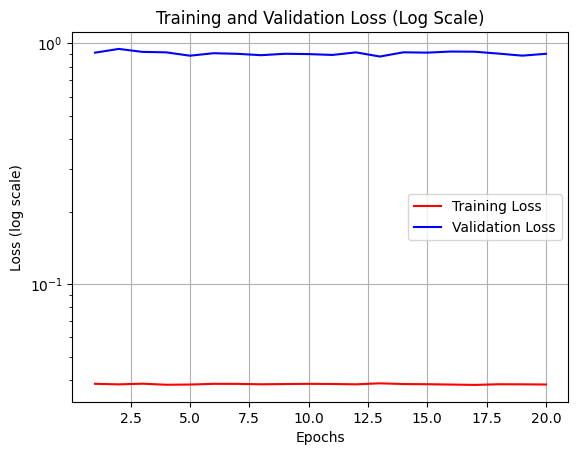

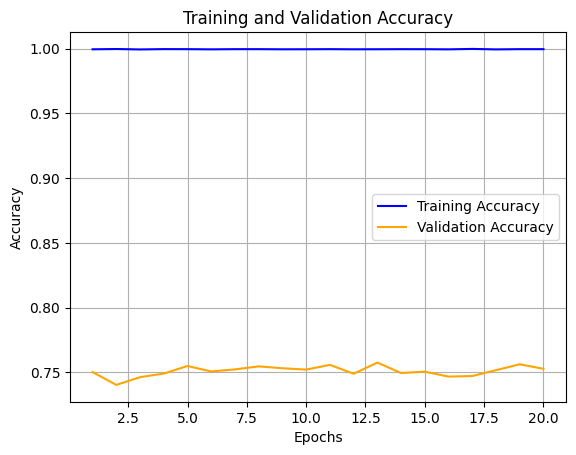

In [86]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [87]:
model.save('Sign_Language_Predict.h5')

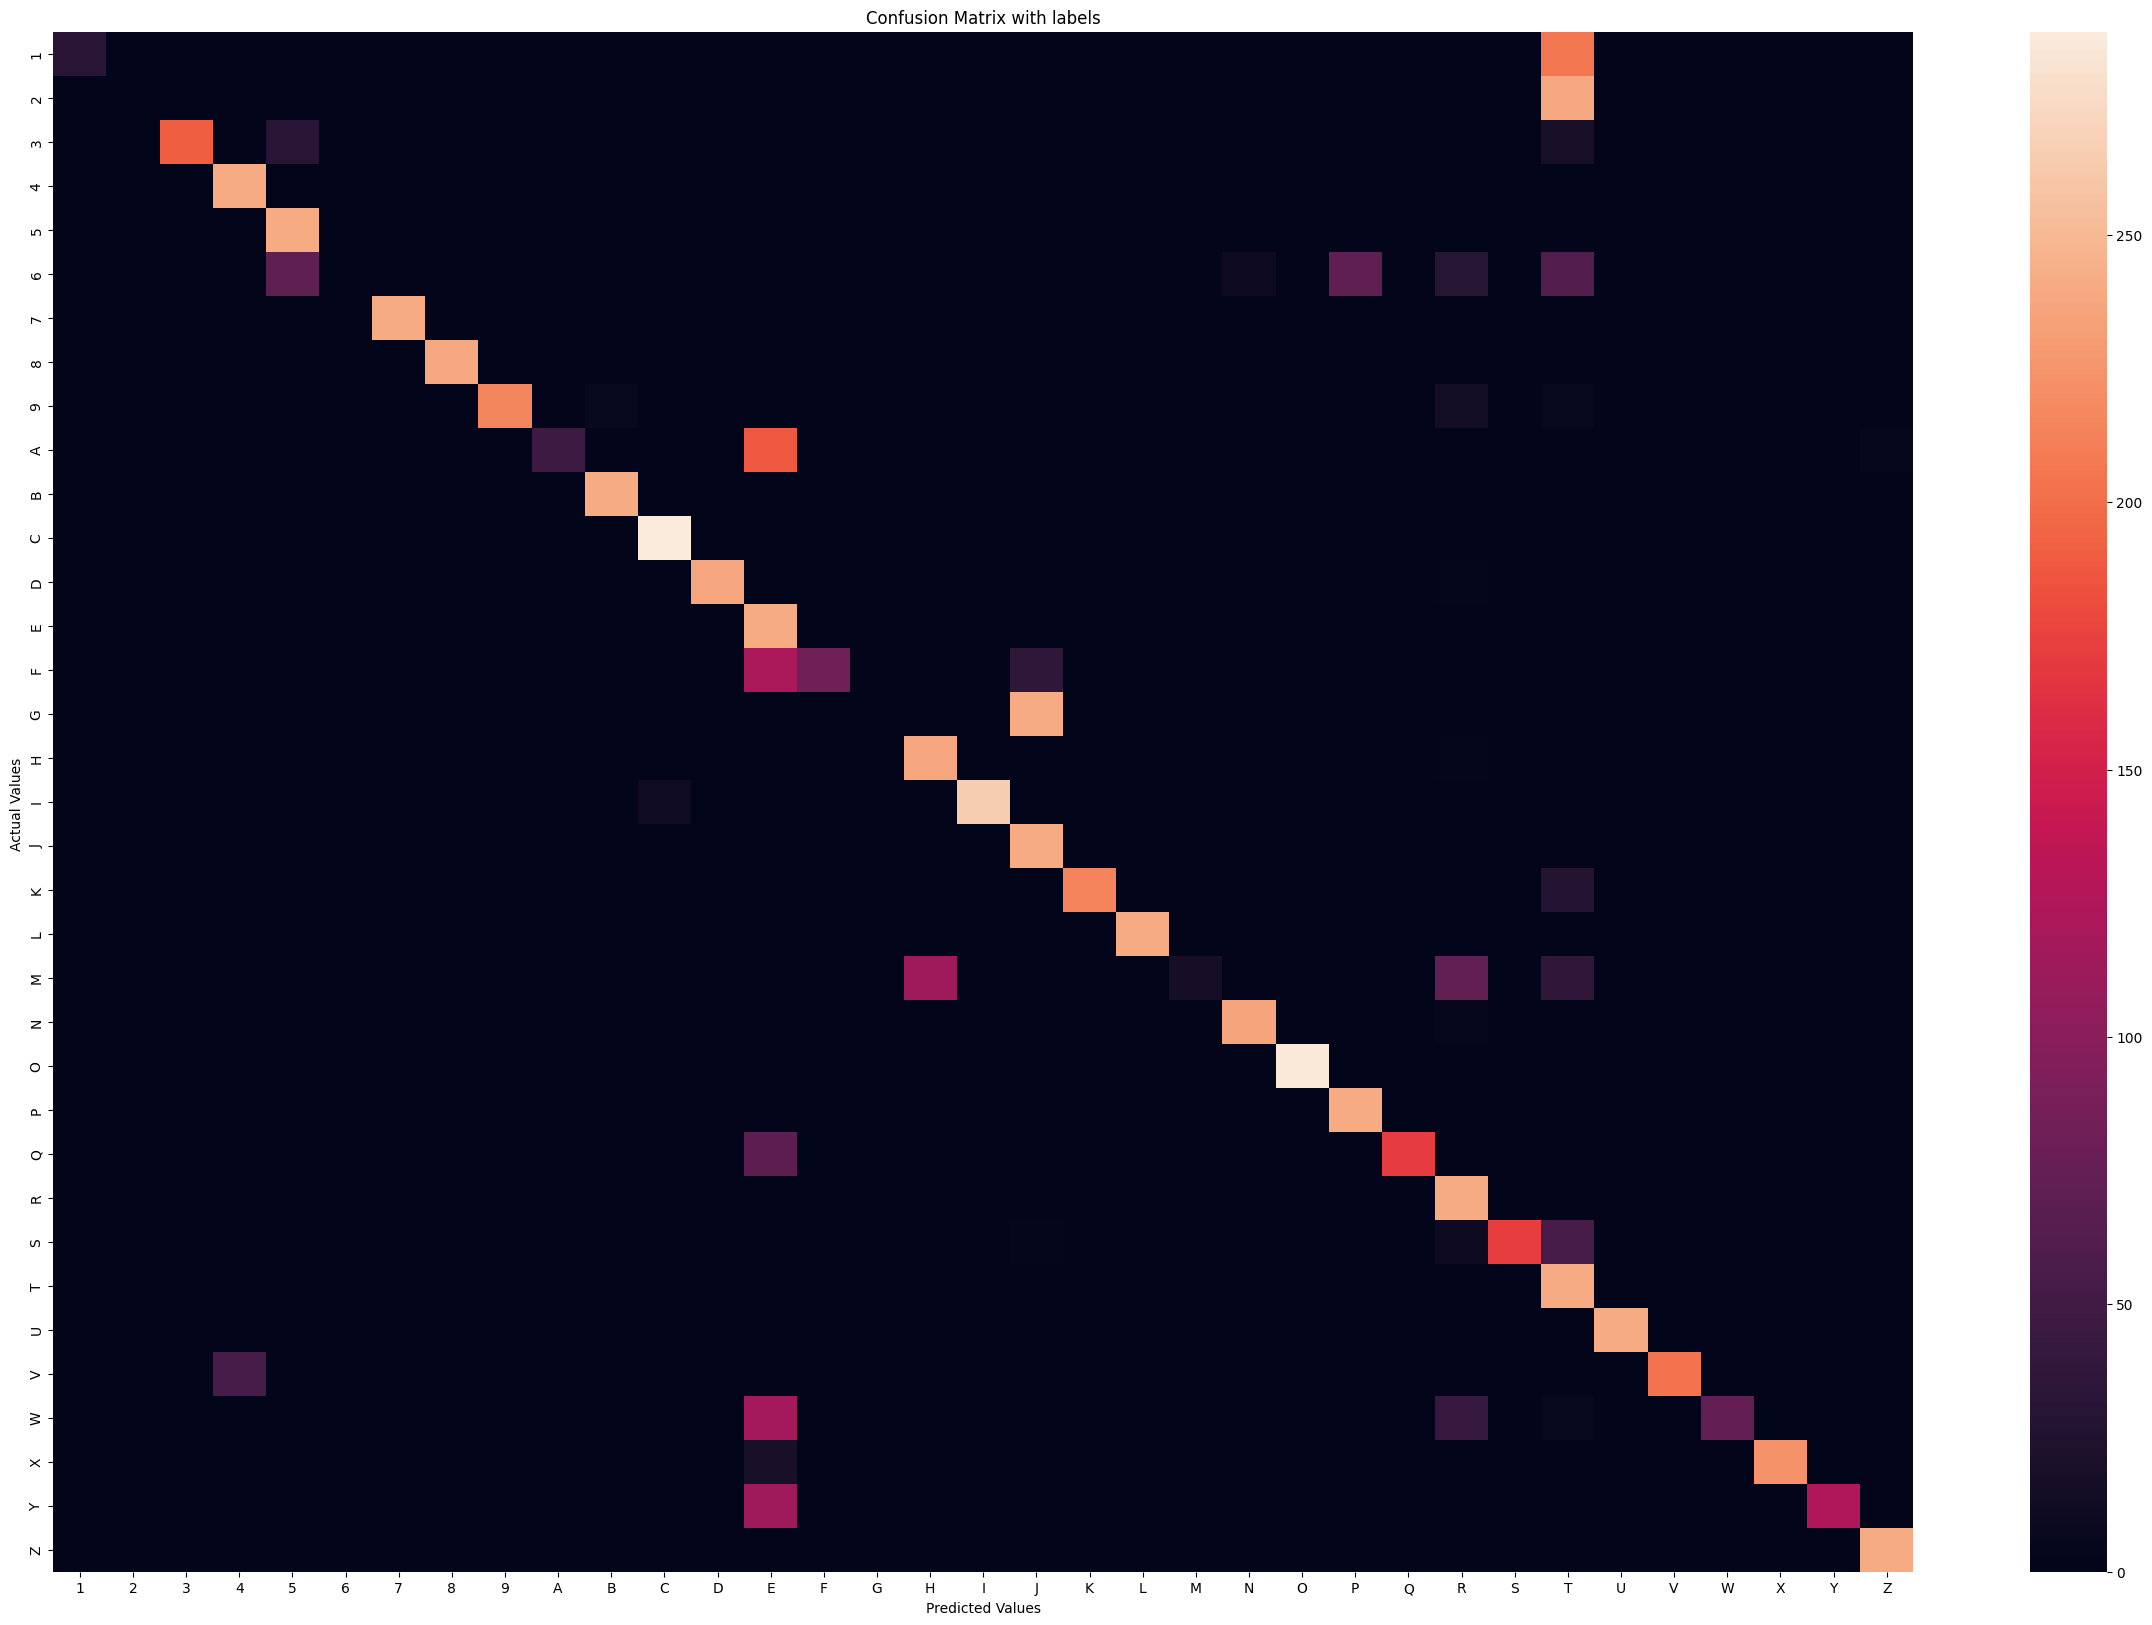

In [88]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(Y_true,Y_pred_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [89]:
confusion = metrics.confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 31   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  0   0 191 ...   0   0   0]
 ...
 [  0   0   0 ... 223   0   0]
 [  0   0   0 ...   0 125   0]
 [  0   0   0 ...   0   0 240]]


In [90]:
model=tf.keras.models.load_model('Sign_Language_Predict.h5')

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us now try to upload an image and let our model predict it.

The map_characters = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: 'A', 10: 'B', 11: 'C', 12: 'D',
                  13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P',
                  25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z'}

In [99]:
uploaded = files.upload()

for filename in uploaded.keys():
    image_path=filename

def preprocess_test_image(image_path):
    img = cv2.imread(image_path, 0)

    minValue = 70
    blur = cv2.GaussianBlur(img, (5,5), 2)
    th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    _, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    res = cv2.resize(res, (64, 64))
    res = img_to_array(res)
    res = res.astype('float32') / 255.0
    res = np.expand_dims(res, axis=0)

    return res

processed_img = preprocess_test_image(image_path)

pred = model.predict(processed_img)
predicted_class = np.argmax(pred)

print(f"Predicted Sign Language Character: {map_characters[predicted_class]}")

Saving sss.jpg to sss.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Sign Language Character: S
